In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from tqdm import tqdm
import re
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def normalize_pfm(pfm):
    """Convert PFM to PPM by normalizing each column."""
    pfm += 0.08
    return pfm / pfm.sum(axis=0)

def pearson_correlation(col1, col2):
    col1 = col1.reshape((-1))
    col2 = col2.reshape((-1))
    """Compute Pearson correlation coefficient using NumPy."""
    mean_col1 = np.mean(col1)
    mean_col2 = np.mean(col2)
    numerator = np.sum((col1 - mean_col1) * (col2 - mean_col2))
    denominator = np.sqrt(np.sum((col1 - mean_col1) ** 2) * np.sum((col2 - mean_col2) ** 2))
    if denominator == 0:
        return 0  # Avoid division by zero
    return numerator / denominator
    
def cross_correlation(pfm1, pfm2, padding_1=20, padding_2=20):
    """Compute cross-correlation between two PFMs with different shapes."""
    # Normalize the PFMs
    ppm1 = normalize_pfm(np.copy(pfm1))
    ppm2 = normalize_pfm(np.copy(pfm2))
    ppm1 -= np.ones_like(ppm1) * 0.25
    ppm2 -= np.ones_like(ppm2) * 0.25
    ppm1 = np.concatenate([np.zeros((4, padding_1)), ppm1, np.zeros((4, padding_1))], axis=1)
    ppm2 = np.concatenate([np.zeros((4, padding_2)), ppm2, np.zeros((4, padding_2))], axis=1)
    len1, len2 = ppm1.shape[1], ppm2.shape[1]
    larger_ppm, smaller_ppm = (ppm1, ppm2) if len1 >= len2 else (ppm2, ppm1)
    larger_len, smaller_len = max(len1, len2), min(len1, len2)
    scores = []
    for offset in range(0, max(larger_len - smaller_len, 1)):
        score = pearson_correlation(larger_ppm[:, offset:offset + smaller_len],  smaller_ppm)
        scores.append(score)

    # Get reverse complement and calculate cross correlation again
    larger_ppm = larger_ppm[::-1][:, ::-1]
    for offset in range(0, max(larger_len - smaller_len, 1)):
        score = pearson_correlation(larger_ppm[:, offset:offset + smaller_len],  smaller_ppm)
        scores.append(score)
    return scores

In [3]:
data_dir = "/home/yanhu/data/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome/de_novo_motifs"
plot_dir = "/home/yanhu/data/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome/plots/de_novo_motifs"

# Load PFMs of de novo motifs
with open(os.path.join(data_dir, "denovo_pfm.pkl"), "rb") as f:
    de_novo_PFMs = pickle.load(f)
for TF in de_novo_PFMs:
    de_novo_PFMs[TF] = np.transpose(de_novo_PFMs[TF])

# Load PFMs of cisBP motifs
with open(os.path.join(data_dir, "cisbp_pfm.pkl"), "rb") as f:
    cisBP_PFMs = pickle.load(f)

In [4]:
cisBP_TF = "Ets1"
cor_dict = {}
partner_dict = {}

# For each de novo motif, calculate max cross-correlation with the selected known motif
for de_novo_TF in tqdm(de_novo_PFMs):
    cor_dict[de_novo_TF] = np.max(cross_correlation(
        de_novo_PFMs[de_novo_TF], cisBP_PFMs[cisBP_TF],
        padding_1=10, padding_2=0
    ))

    # If correlation is high, it means that the de novo motif contains our known motif
    if cor_dict[de_novo_TF] > 0.7:

        # Try to see if the current de novo motif contains any other known motif as binding partners
        # We scan through each candidate partner
        for candidate_partner in cisBP_PFMs:

            # Calculate similarity between the candidate and the de novo motif
            # This is to test if the candidate is a part of the de novo motif
            candidate_de_novo_cor = cross_correlation(
                de_novo_PFMs[de_novo_TF], cisBP_PFMs[candidate_partner],
                padding_1=10, padding_2=0
            )
            candidate_de_novo_similarity = np.max(candidate_de_novo_cor)

            # Calculate similarity between the candidate and the selected cisBP
            # This is to exclude trivial cases where another identical/similar motif is overlapping our selected motif
            candidate_cisBP_similarity = np.max(cross_correlation(
                cisBP_PFMs[cisBP_TF], cisBP_PFMs[candidate_partner],
                padding_1=10, padding_2=0
            ))

            if candidate_de_novo_similarity > 0.7:
                hetero_dimer = candidate_cisBP_similarity < 0.7 # Hetemro dimer where the partner is a different TF
                homo_dimer = np.sum(np.array(candidate_de_novo_cor) > 0.7) > 1 # Homo dimer where there is a second match of the same TF
                if hetero_dimer or homo_dimer:     
                    if de_novo_TF not in partner_dict or candidate_de_novo_similarity > partner_dict[de_novo_TF][1]:
                        partner_dict[de_novo_TF] = [candidate_partner, candidate_de_novo_similarity]

100%|████████████████████████████████████████████████████████████████████████| 182/182 [01:20<00:00,  2.27it/s]


In [6]:
partner_dict

{'pos_patterns.pattern_40_report_just_sum_y': ['Cbfb', 0.7687039707885545],
 'pos_patterns.pattern_42_report_just_sum_o': ['Ikzf3', 0.8834047310156651],
 'pos_patterns.pattern_14_report_count_o': ['Runx3', 0.8132586497044955],
 'pos_patterns.pattern_29_report_just_sum_y': ['Runx3', 0.7817147775047566],
 'pos_patterns.pattern_13_report_count_y': ['Runx3', 0.836065960542822],
 'pos_patterns.pattern_89_report_just_sum_o': ['Runx2', 0.8159035144476002],
 'pos_patterns.pattern_51_report_count_o': ['Nfatc3', 0.8429569234424795],
 'pos_patterns.pattern_0_report_count_y': ['Spi1', 0.8006121483334101],
 'pos_patterns.pattern_79_report_just_sum_o': ['Runx3', 0.9252317643821204],
 'pos_patterns.pattern_52_report_just_sum_y': ['Cbfb', 0.8564285279894187],
 'pos_patterns.pattern_29_report_count_o': ['Spi1', 0.7743075464260892],
 'pos_patterns.pattern_41_report_just_sum_o': ['Junb', 0.9135291456657199],
 'pos_patterns.pattern_49_report_just_sum_o': ['Runx2', 0.8536022045101241],
 'pos_patterns.patte

In [18]:
# Find Runx-Ets composite motifs
if cisBP_TF == "Ets1":
    Runx_composite = []
    for partner_id, partner_info in partner_dict.items():
        if re.match(r'^(Runx|Cbfb)', partner_info[0]) is not None:
            Runx_composite.append(partner_id)
    Runx_composite = pd.DataFrame(Runx_composite)
    Runx_composite.to_csv(
        os.path.join(data_dir, cisBP_TF + "_Runx_composite_motifs.tsv"), 
        sep="\t", index=None)

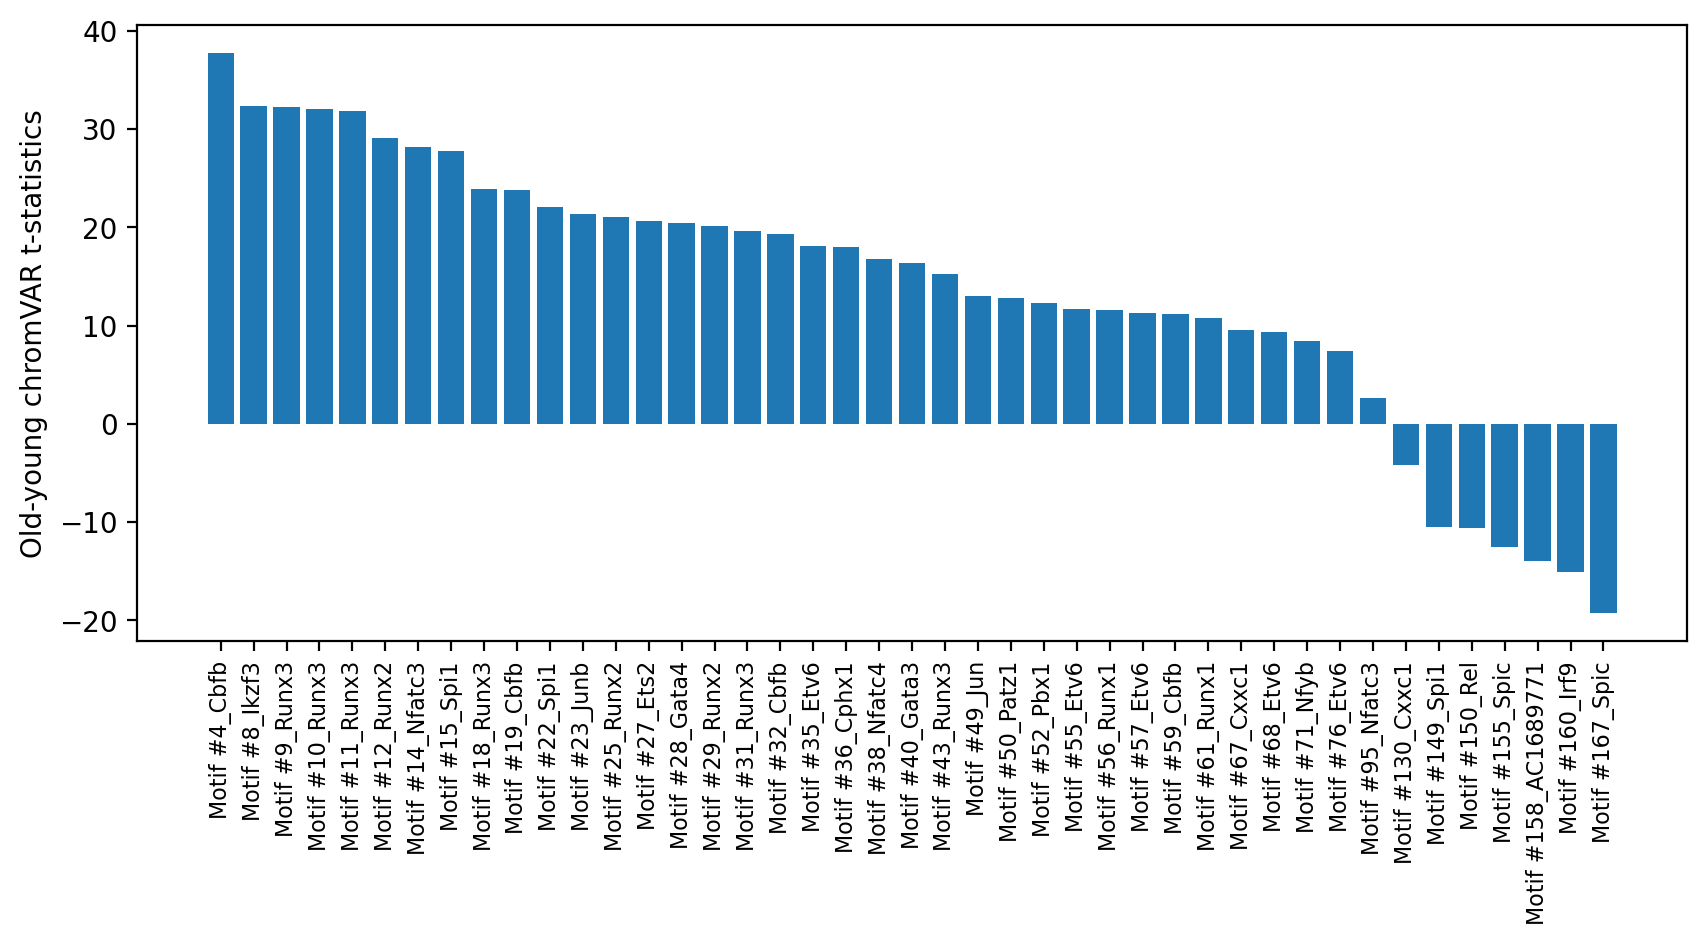

In [255]:
# Retrive the index of the composite motifs among all de novo motifs
denovo_info = pd.read_csv(os.path.join(data_dir, "denovo_res2_all.txt"), sep="\t")
denovo_list = denovo_info["cluster"].tolist()
composite_motif_inds = [denovo_list.index(i) for i in partner_dict.keys()]
    
partner_TFs = [i[0] for i in partner_dict.values()]
plt.figure(dpi=200, figsize=(10,4))
plt.bar(
    x = np.arange(len(composite_motif_inds)),
    height = denovo_info["stats"][composite_motif_inds])
plt.xticks(
    np.arange(len(composite_motif_inds)),
    ["Motif #" + str(composite_motif_inds[i] + 1) + "_" + partner_TFs[i] \
     for i in np.arange(len(composite_motif_inds))],
    rotation = 90, fontsize=8
)
plt.ylabel("Old-young chromVAR t-statistics")
plt.savefig(os.path.join(plot_dir, cisBP_TF + "_composite_motif_aging_stats.pdf"))
plt.show()

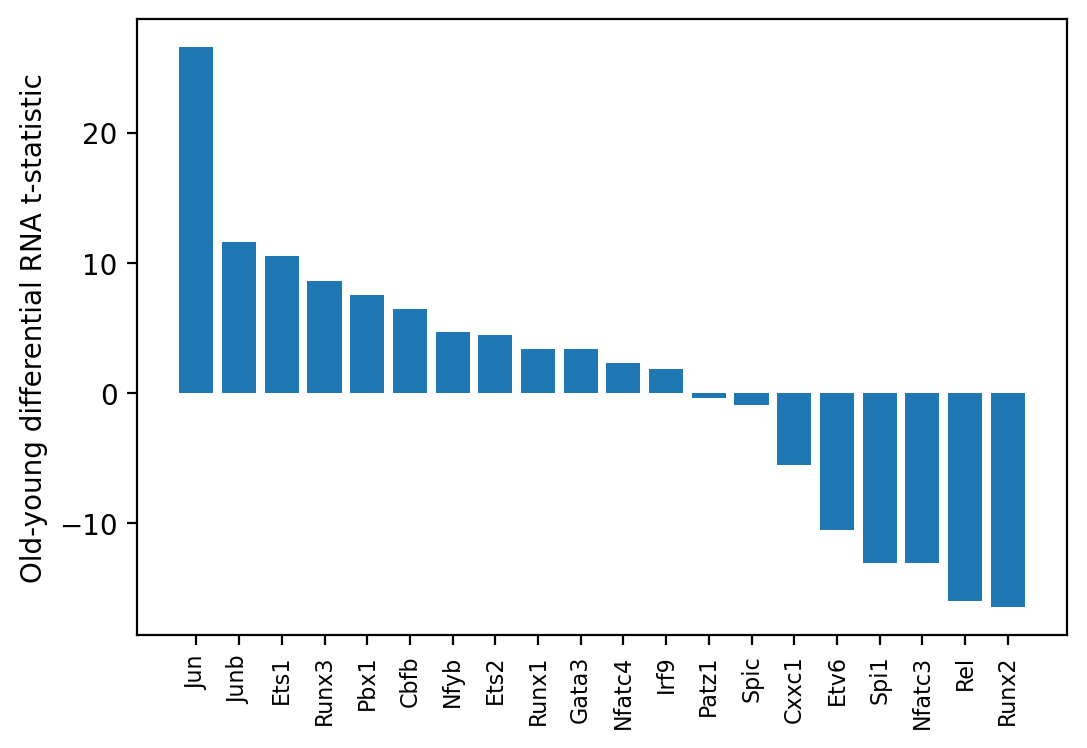

In [287]:
# For all partner TFs, visualize their RNA change in aging
diff_RNA = pd.read_csv(os.path.join("/home/yanhu/data/PRINT/multiScaleFootprinting/data/mHSCAging10xMultiome", "diffRNA.tsv"), sep = "\t")
partner_diff_RNA_dict = {}
for partner_info in partner_dict.values():
    partner_TF = partner_info[0]
    if partner_TF in diff_RNA.index:
        partner_diff_RNA_dict[partner_TF] = diff_RNA.loc[partner_TF].stat
partner_diff_RNA_dict[cisBP_TF] = diff_RNA.loc[cisBP_TF].stat
partner_TFs = np.array(list(partner_diff_RNA_dict.keys()))
partner_stats = np.array(list(partner_diff_RNA_dict.values()))
partner_order = np.argsort(-partner_stats)
plt.figure(dpi=200, figsize=(6,4))
plt.bar(
    x = np.arange(len(partner_order)),
    height = partner_stats[partner_order])
plt.xticks(
    np.arange(len(partner_order)),
    partner_TFs[partner_order],
    rotation = 90, fontsize=8
)
plt.ylabel("Old-young differential RNA t-statistic")
plt.savefig(os.path.join(plot_dir, cisBP_TF + "_partner_aging_RNA_stats.pdf"))
plt.show()

In [297]:
de_novo_TF = "pos_patterns.pattern_9_report_just_sum_o"
cor_dict = {}

# For each de novo motif, calculate max cross-correlation with the selected known motif
for cisBP_TF in tqdm(cisBP_PFMs):
    corr = np.max(cross_correlation(
        de_novo_PFMs[de_novo_TF], cisBP_PFMs[cisBP_TF],
        padding_1=10, padding_2=0
    ))
    if corr > 0.8:
        cor_dict[cisBP_TF] = corr

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 890/890 [00:00<00:00, 1484.17it/s]


In [298]:
cor_dict

{'Nfya': 0.8630869219727091,
 'Nfyb': 0.8599691294248816,
 'Nfyc': 0.8449519399032112,
 'Pbx3': 0.8115892894682969}